# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### *Data Problem definition*

Develop a machine learning model to predict car price of a used car (that a user is willing to pay) based on the features of the car. The target of the model would be the car price. Additional part of the problem is to understand which features have most impact on the target of the model.

Analyze different regression models and pick the best model by using MSE and MAE for validating the predictions and performance of the models. Use grid search to optimize the parameters towards finding the best model


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

from sklearn import set_config
set_config(display="diagram")


import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
vehicles_df = pd.read_csv('data/vehicles.csv')

In [3]:
vehicles_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
vehicles_df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [5]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

## Data Exploration

### Initial exploration 

Some of the columns can be eliminated right away from analysis as they are likely not useful. Some explanation on why I am not including the following columns:

**'id'**: this is just an identifier and does not capture a feature of the vehicle

**'region'**: this could be impactful but given these are all in the US, and the number of unique values are large, analyzing this can become complex with little benefit

**'VIN'**: is another identifier that does not capture any useful information about the car

**'paint_color'**: could be useful but likely will have less impact

**'state'**: same reasoning as region

**'model'**: will also drop the model column to make the analysis simpler, even though model likely has a direct impact on price because of branding. This column has too many string values which will complicate the training a lot especially when using onehotencoder for this. 

### Further exploration

Analyzing other columns. Looking at the spread of the columns among its different values. The initial idea is that if most of the rows have the same value, it may not be useful. For example, if we take an extreme case, if all vehicles are of fuel type gas, it does not provide useful information

For 9 of the following columns we plot the counts against values and look for skews and outliers

In [6]:
# analyze remaining object columns

columns = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 
           'transmission', 'drive', 'size', 'type']
value_counts = [vehicles_df[column].value_counts() for column in columns]


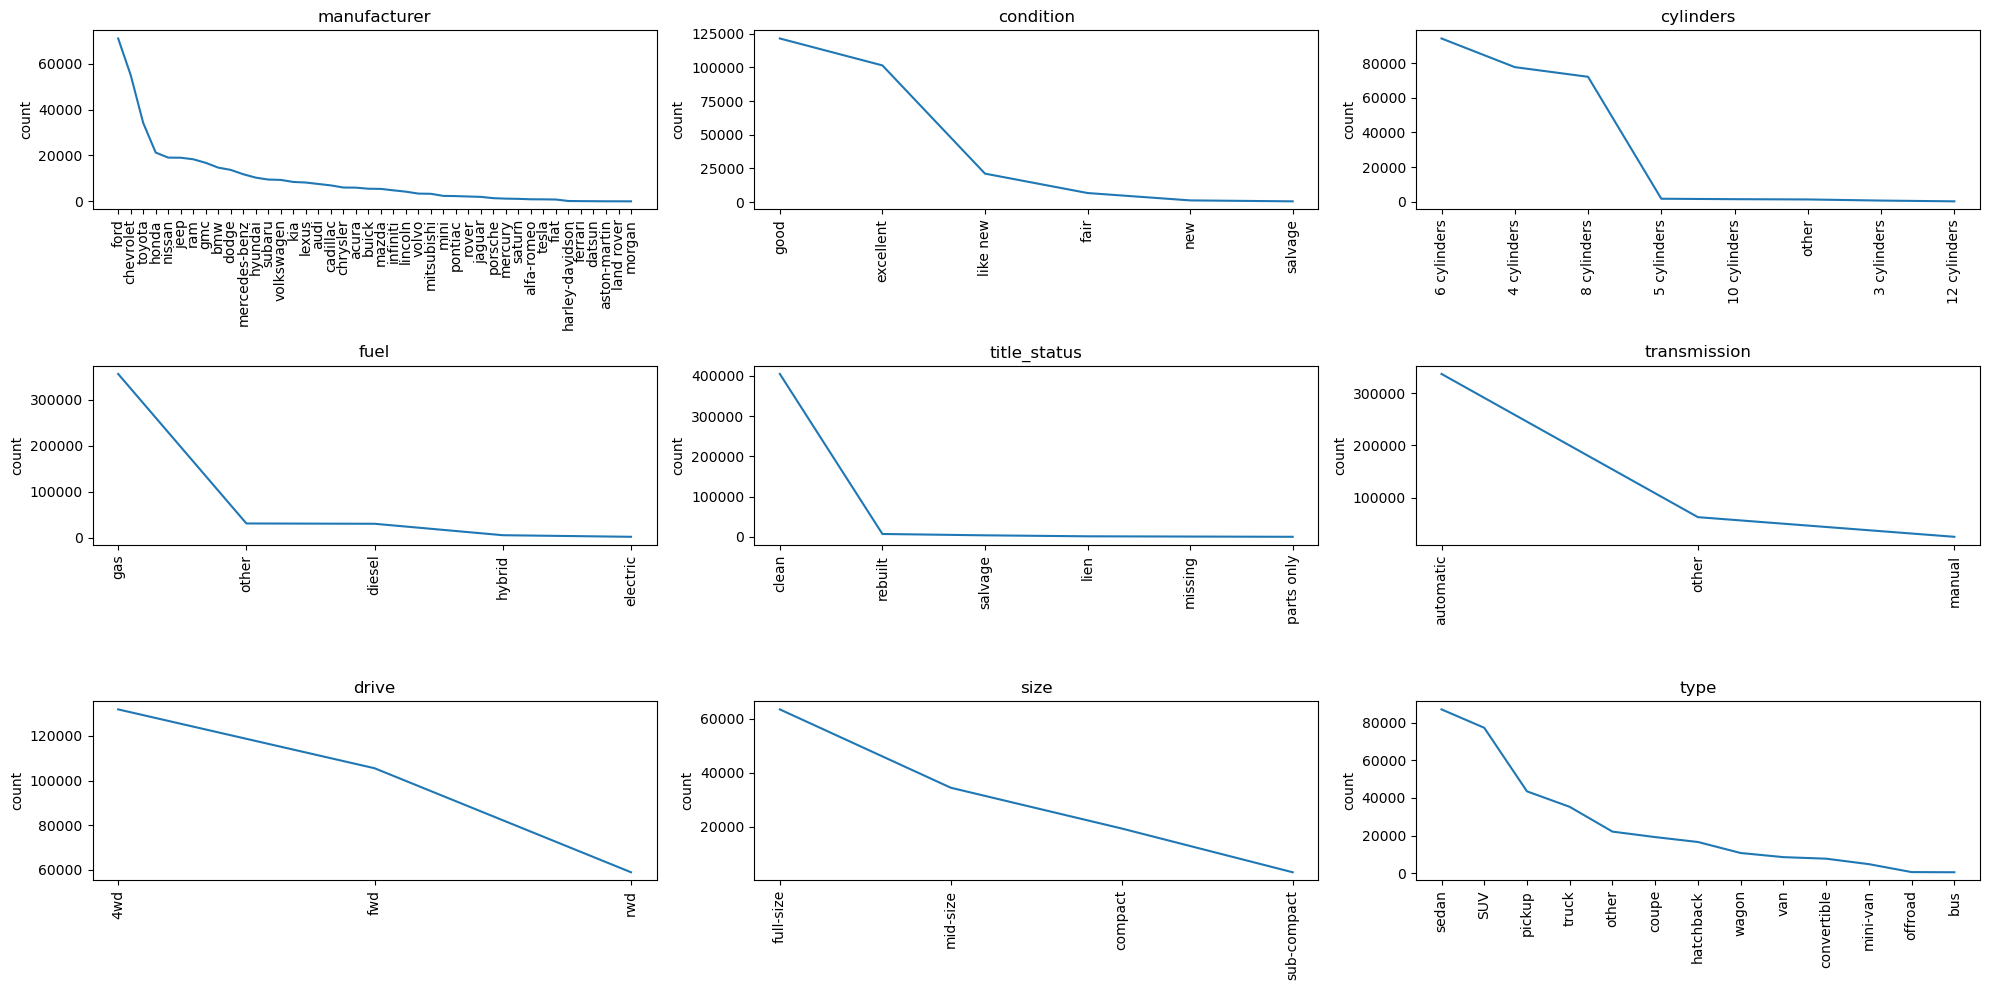

In [7]:
# visualize counts of the vehicles for each value of specific column
fig, axs = plt.subplots(3, int(len(columns) / 3), figsize=(20,10))

for i in range(0, len(columns)):
    x, y = int(i/3), int(i%3)
    axs[x, y].plot(value_counts[i])
    axs[x, y].set_title(columns[i])
    axs[x, y].set_ylabel('count')
    axs[x, y].set_xticks(range(len(value_counts[i].index)))
    axs[x, y].set_xticklabels(value_counts[i].index, rotation=90)
    
plt.tight_layout()
plt.show()

### Further exploration (conclusion)

From above it is clear that the following columns do not provide a lot of value:

**'title_status'**: most of the vehicles are in clean state and there is very little variance

**'fuel'**: most of the vehicles are gas, and there is very little variance


In [8]:
# look at remaining columns and analyze further
clean_df = vehicles_df.drop(['id', 'region', 'VIN', 'paint_color', 'state', 'title_status', 'fuel'], axis=1)

In [9]:
# check to see how many rows get dropped if we remove all rows with missing values
clean_df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 82051 entries, 31 to 426836
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         82051 non-null  int64  
 1   year          82051 non-null  float64
 2   manufacturer  82051 non-null  object 
 3   model         82051 non-null  object 
 4   condition     82051 non-null  object 
 5   cylinders     82051 non-null  object 
 6   odometer      82051 non-null  float64
 7   transmission  82051 non-null  object 
 8   drive         82051 non-null  object 
 9   size          82051 non-null  object 
 10  type          82051 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 7.5+ MB


### Remark
If we blindly drop all rows with NaN values, the data set reduces by a lot (>80%). We need to explore more

In [10]:
# Analyzing some the columns which have very few rows

for col in ['cylinders', 'drive', 'size', 'type', 'condition']:
    print(vehicles_df[col].value_counts(normalize=True))
    print('')

cylinders
6 cylinders     0.377882
4 cylinders     0.311563
8 cylinders     0.289171
5 cylinders     0.006870
10 cylinders    0.005839
other           0.005209
3 cylinders     0.002628
12 cylinders    0.000839
Name: proportion, dtype: float64

drive
4wd    0.445151
fwd    0.356100
rwd    0.198749
Name: proportion, dtype: float64

size
full-size      0.526597
mid-size       0.286063
compact        0.160838
sub-compact    0.026502
Name: proportion, dtype: float64

type
sedan          0.260630
SUV            0.231374
pickup         0.130261
truck          0.105619
other          0.066193
coupe          0.057493
hatchback      0.049691
wagon          0.032187
van            0.025591
convertible    0.023145
mini-van       0.014445
offroad        0.001823
bus            0.001548
Name: proportion, dtype: float64

condition
good         0.480489
excellent    0.401411
like new     0.083782
fair         0.026779
new          0.005163
salvage      0.002378
Name: proportion, dtype: float64



### Remark
We can impute the missing values for 'cylinders', 'drive', 'size', 'type' columns by looking at the model and filling in the most common value for that model (use the mode() if it exists picking the first one in case of multiple values)

**This is simplistic. Explore if we can fix the data by distributing the values in the same proportion as their ratios**

In [11]:
# impute size by looking at model - assign the most common features by using mode() to aggregate

for col in ['cylinders', 'drive', 'size', 'type']:
    mode = clean_df.groupby('model')[col].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
    clean_df[col] = clean_df[col].fillna(clean_df['model'].map(mode))


In [12]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     386247 non-null  object 
 6   odometer      422480 non-null  float64
 7   transmission  424324 non-null  object 
 8   drive         400936 non-null  object 
 9   size          336417 non-null  object 
 10  type          414292 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 35.8+ MB


### Final remark on data exploration
There are a lot of rows that do not have 'condition' value but this could be an important column as the condition of the car should be an important feature to predict car price. As a result we will keep this column even if it reduces the samples by a lot (almost 43%)
Drop the model column as it is not very useful

In [13]:
clean_df = clean_df.drop(['model', 'manufacturer'], axis=1).dropna()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187246 entries, 28 to 426875
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         187246 non-null  int64  
 1   year          187246 non-null  float64
 2   condition     187246 non-null  object 
 3   cylinders     187246 non-null  object 
 4   odometer      187246 non-null  float64
 5   transmission  187246 non-null  object 
 6   drive         187246 non-null  object 
 7   size          187246 non-null  object 
 8   type          187246 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 14.3+ MB


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

### Remark
We start with partially cleaned data and start looking at other issues

In [14]:
# clean up the target column which has 0 value in price column. 
#For now assume car salespeople are not interested in free cars

clean_df = clean_df.loc[clean_df['price'] != 0]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178703 entries, 28 to 426875
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         178703 non-null  int64  
 1   year          178703 non-null  float64
 2   condition     178703 non-null  object 
 3   cylinders     178703 non-null  object 
 4   odometer      178703 non-null  float64
 5   transmission  178703 non-null  object 
 6   drive         178703 non-null  object 
 7   size          178703 non-null  object 
 8   type          178703 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 13.6+ MB


In [15]:
col_transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary', sparse_output=False), ['transmission', 'drive', 'size', 'type']),
                                          (OrdinalEncoder(categories=[['new', 
                                                                      'like new', 
                                                                      'excellent', 
                                                                      'good', 
                                                                      'fair', 
                                                                      'salvage']]), ['condition']),
                                          (OrdinalEncoder(categories=[['4 cylinders', 
                                                                      '5 cylinders', 
                                                                      '6 cylinders', 
                                                                      '8 cylinders', 
                                                                      '10 cylinders', 
                                                                      '3 cylinders',
                                                                      '12 cylinders',
                                                                      'other']]), ['cylinders']),
                                         remainder='passthrough')

X_Array = col_transformer.fit_transform(clean_df.drop('price', axis=1))


In [16]:
X = pd.DataFrame(X_Array, columns = col_transformer.get_feature_names_out())

# taking the log of price object - to keep the MSE's more understandable
# and less sensitive to the larger values. Also, as we do not need to
# predict car values, but need this to find the impact of features on car
# values, this should be ok. Eventually use TransformedTargetRegressor

y = np.log(clean_df['price'])

print(y.shape)
X.info()

(178703,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178703 entries, 0 to 178702
Data columns (total 27 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   onehotencoder__transmission_automatic  178703 non-null  float64
 1   onehotencoder__transmission_manual     178703 non-null  float64
 2   onehotencoder__transmission_other      178703 non-null  float64
 3   onehotencoder__drive_4wd               178703 non-null  float64
 4   onehotencoder__drive_fwd               178703 non-null  float64
 5   onehotencoder__drive_rwd               178703 non-null  float64
 6   onehotencoder__size_compact            178703 non-null  float64
 7   onehotencoder__size_full-size          178703 non-null  float64
 8   onehotencoder__size_mid-size           178703 non-null  float64
 9   onehotencoder__size_sub-compact        178703 non-null  float64
 10  onehotencoder__type_SUV                178703 

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

## 1. Model with principal components PCA to form a baseline MSE
**Goal**: Find the best model using LinearRegression that minimizes the test mean squared error. This is to form a baseline model, note that we cannot use this to tell the sales person as to which features contribute most to an optimal selling price

**Approach**: 
- Find the optimal number of PCA's that are needed
- Utilize the PCA's to find the best polynomial degree which gives the minimal MSE
- Split the data with PCA columns into test and train data and validate

In [17]:
# do PCA analysis
pca = PCA(random_state=42).fit(X)
print(pca.singular_values_/pca.singular_values_.sum())

[9.99915125e-01 4.85367651e-05 6.64544139e-06 3.59858923e-06
 3.11009346e-06 2.71680971e-06 2.41580633e-06 2.08923529e-06
 1.99779244e-06 1.85504538e-06 1.71237137e-06 1.57859468e-06
 1.24938916e-06 1.10734545e-06 1.03501160e-06 9.43138520e-07
 8.06820077e-07 7.87426692e-07 7.61145317e-07 7.19891449e-07
 6.89190377e-07 2.86543643e-07 2.27479175e-07 4.69716526e-09
 3.39224158e-13 5.54776625e-15 0.00000000e+00]


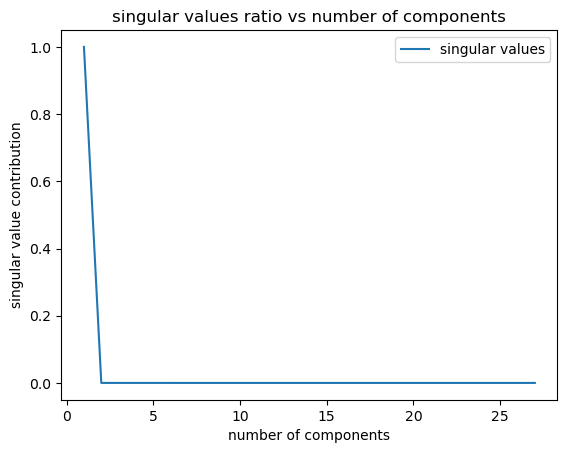

In [18]:
# visualize to see how many features is optimal
plt.plot(range(1, len(pca.singular_values_)+1), pca.singular_values_/pca.singular_values_.sum())
plt.legend(['singular values', 'explained variance ratio'])
plt.xlabel('number of components')
plt.ylabel('singular value contribution')
plt.title('singular values ratio vs number of components')
plt.show()

In [19]:
# from above 3 principal components should account for most of the explained variance ratio
PCA_df = pd.DataFrame(PCA(n_components=3).fit_transform(X), columns=['PCA1', 'PCA2', 'PCA3'])
PCA_df.info()                  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178703 entries, 0 to 178702
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PCA1    178703 non-null  float64
 1   PCA2    178703 non-null  float64
 2   PCA3    178703 non-null  float64
dtypes: float64(3)
memory usage: 4.1 MB


In [20]:
PCA_Train, PCA_Test, y_train, y_test = train_test_split(PCA_df, y, test_size=0.3)


In [21]:
# create a pipeline with Linear Regression
test_mses = []
train_mses = []

for degree in range(1, 7):
    pipe = Pipeline([('poly', PolynomialFeatures(degree=degree, include_bias=False)), 
                     ('scaler', StandardScaler()), 
                     ('linreg', LinearRegression())])
    pipe.fit(PCA_Train, y_train)
    train_mses.append(mean_squared_error(pipe.predict(PCA_Train), y_train))
    test_mses.append(mean_squared_error(pipe.predict(PCA_Test), y_test))

print(train_mses)
print(test_mses)
print(f'Best mse = {min(test_mses)}, degree = {test_mses.index(min(test_mses))+1}')
    

[1.3405336851083958, 1.1856089229100697, 1.1542186556151166, 1.1450201020295672, 1.1283665149856463, 1.116124137355053]
[1.3394133064044174, 1.1831277990811062, 1.1559299156941514, 1.192226639213804, 1.22134579475168, 1.8315072554299254]
Best mse = 1.1559299156941514, degree = 3


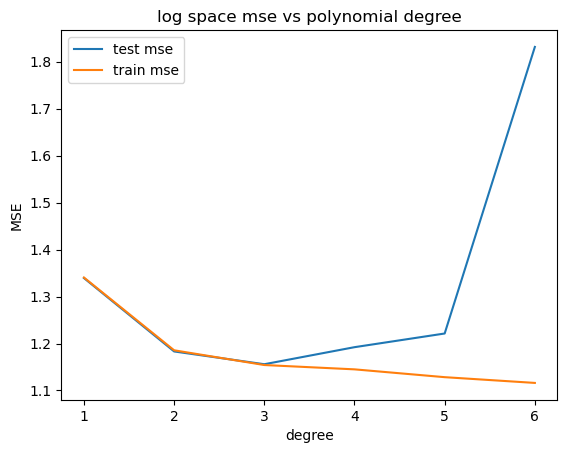

In [22]:
# visualize the test mses vs degree with 3 principal components
plt.plot(range(1, 7), test_mses)
plt.plot(range(1, 7), train_mses)
plt.xlabel('degree')
plt.ylabel('MSE')
plt.title('log space mse vs polynomial degree')
plt.legend(['test mse', 'train mse'])
plt.show()

### Conclusion
With 3 principal components, the model with degree=3 is the best model with MSE of 1.155

As expected the training MSE's keeps going down as the model overfits after degree=3

## 2. Model with Linear regression

In [23]:
X_Train, X_Test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_Train.shape, X_Test.shape, y_train.shape, y_test.shape)

(125092, 27) (53611, 27) (125092,) (53611,)


In [50]:
# create a pipeline with Linear Regression
test_mses = []
train_mses = []
best_pipe = ...
best_mse = float('inf')

for degree in range(1, 4):
    pipe = Pipeline([('poly', PolynomialFeatures(degree=degree, include_bias=False)), 
                     ('scaler', StandardScaler()), 
                     ('linreg', LinearRegression())])
    pipe.fit(X_Train, y_train)
    train_mses.append(mean_squared_error(pipe.predict(X_Train), y_train))
    test_mse = mean_squared_error(pipe.predict(X_Test), y_test)
    if test_mse < best_mse:
        best_pipe = pipe
        best_mse = test_mse
    
    test_mses.append(test_mse)

print(train_mses)
print(test_mses)
print(f'Best mse = {min(test_mses)}, degree = {test_mses.index(min(test_mses))+1}')

[1.2339096618190522, 0.9560022001796135, 0.8248537549017823]
[1.1761392813865572, 0.9130212876197844, 17.688919198920885]
Best mse = 0.9130212876197844, degree = 2


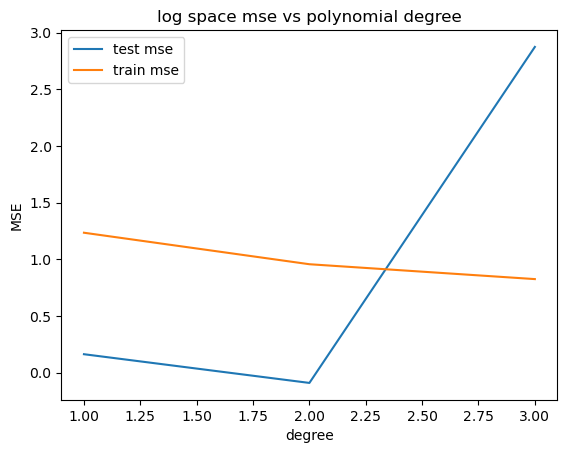

In [51]:
# visualize the test mses vs degree with 3 principal components
# plot with log of test mses as it increases a lot after degree=2
plt.plot(range(1, 4), np.log(test_mses))
plt.plot(range(1, 4), train_mses)
plt.xlabel('degree')
plt.ylabel('MSE')
plt.title('log space mse vs polynomial degree')
plt.legend(['test mse', 'train mse'])
plt.show()

Text(0, 0.5, 'price')

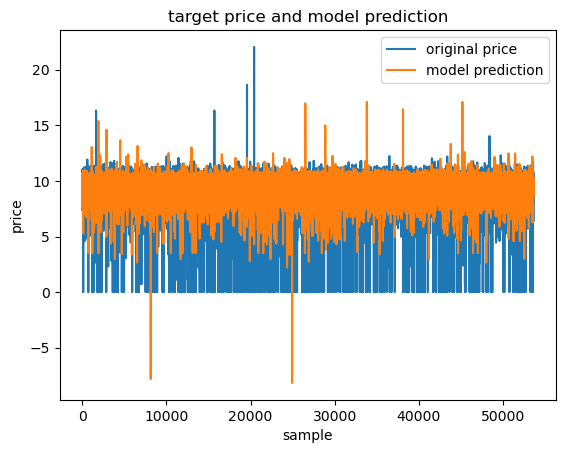

In [52]:
test_predictions = best_pipe.predict(X_Test)
plt.plot(range(0, len(y_test)), y_test)
plt.plot(range(0, len(test_predictions)), test_predictions)
plt.legend(['original price', 'model prediction'])
plt.title('target price and model prediction')
plt.xlabel('sample')
plt.ylabel('price')

In [53]:
# look at the best model and see which features most impact the price
r = permutation_importance(best_pipe, X_Test, y_test, n_repeats=30, random_state=0)

In [54]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_Test.columns[i]:<50} "
              f"{r.importances_mean[i]:.9f}"
              f" +/- {r.importances_std[i]:.9f}")

onehotencoder__transmission_automatic              3.224679614 +/- 0.037427834
onehotencoder__size_full-size                      3.103243314 +/- 0.028098848
onehotencoder__size_mid-size                       2.619265167 +/- 0.032291911
onehotencoder__drive_fwd                           2.456858965 +/- 0.031339198
onehotencoder__drive_4wd                           2.286473520 +/- 0.024899184
onehotencoder__type_sedan                          1.901347323 +/- 0.014812807
onehotencoder__transmission_other                  1.884759004 +/- 0.020366818
onehotencoder__drive_rwd                           1.858972900 +/- 0.025023356
onehotencoder__transmission_manual                 1.654568229 +/- 0.016937009
onehotencoder__size_compact                        1.574090516 +/- 0.018139443
onehotencoder__type_SUV                            1.468500846 +/- 0.019252684
onehotencoder__type_coupe                          1.138588889 +/- 0.010848418
onehotencoder__type_truck                          0

In [27]:
# Next we will use a sequentialfeatureselector with polynomial degree=2 and use LinearRegression
selector_pipe = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)), 
                 ('scaler', StandardScaler()),
                 ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=6)), 
                 ('linreg', LinearRegression())])

selector_pipe.fit(X_Train, y_train)
train_mse = mean_squared_error(selector_pipe.predict(X_Train), y_train)
test_mse = mean_squared_error(selector_pipe.predict(X_Test), y_test)
print(f'train_mse: {train_mse}')
print(f'test_mse: {test_mse}')


train_mse: 1.1724621497901064
test_mse: 1.1054149590479996


In [28]:
# find the features that were selected
features = selector_pipe.named_steps['poly'].get_feature_names_out()
selector_pipe.named_steps['selector'].get_feature_names_out(features)

array(['remainder__year',
       'onehotencoder__drive_4wd onehotencoder__size_compact',
       'onehotencoder__drive_fwd ordinalencoder-1__condition',
       'onehotencoder__type_SUV ordinalencoder-1__condition',
       'onehotencoder__type_sedan^2', 'remainder__year^2'], dtype=object)

Text(0, 0.5, 'price')

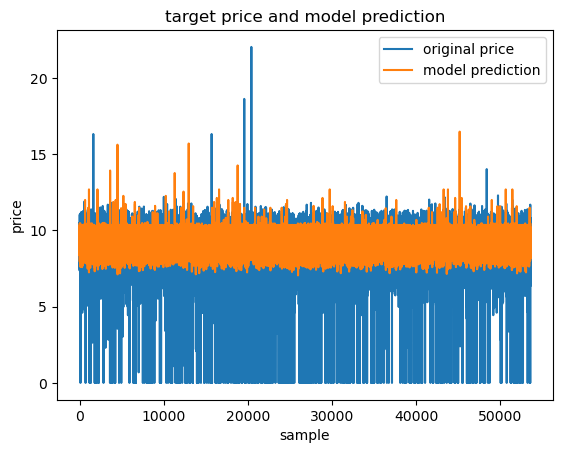

In [29]:
test_predictions = selector_pipe.predict(X_Test)
plt.plot(range(0, len(y_test)), y_test)
plt.plot(range(0, len(test_predictions)), test_predictions)
plt.legend(['original price', 'model prediction'])
plt.title('target price and model prediction')
plt.xlabel('sample')
plt.ylabel('price')

In [48]:
r = permutation_importance(selector_pipe, X_Test, y_test, n_repeats=30, random_state=0)

In [49]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_Test.columns[i]:<50} "
              f"{r.importances_mean[i]:.9f}"
              f" +/- {r.importances_std[i]:.9f}")

remainder__year                                    0.290500895 +/- 0.003550668
onehotencoder__drive_fwd                           0.084196682 +/- 0.001445301
onehotencoder__size_compact                        0.060045918 +/- 0.001961189
onehotencoder__type_sedan                          0.048209036 +/- 0.000924243
onehotencoder__drive_4wd                           0.043473121 +/- 0.001824471
onehotencoder__type_SUV                            0.025450306 +/- 0.000840826
ordinalencoder-1__condition                        0.010320835 +/- 0.000557493


## Conclusion
**Approach**: Tried 2 approaches with Linear Regression

1. Ran multiple iterations with varying degrees on all features with LinearRegression model. Found the best degree which yielded mimimum mse was degree = 2. min MSE was: 0.9031493830422779. Features with most impact on the target price were (in the order of importance):

   - Automatic Transmission
   - full size
   - Transmission type other
   - mid size
   - fwd
   - 4wd
   - manual transmission
   - sedan
   - compact
   - rwd
   - SUV
   - coupe
   - pickup
   - truck
   - hatchback
   - wagon
   - convertible
   - sub-compact
   - van
   - year
   - condition
   - minivan
   - 2 cylnders
     
2. Ran sequential feature selector to select the best 6 features. MSE for this model was: 1.1766657212729077 (higher than the previous approach). Features identified by this model:

   - year
   - fwd drive
   - compact
   - sedan
   - 4wd drive
   - SUV
   - condition


## 3. Model with Ridge regression

In [30]:
ridge_pipe = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)), 
                       ('scaler', StandardScaler()), 
                       ('ridge', Ridge())])
search_grid = {'ridge__alpha': 10 ** np.linspace(-5, 4, 10)}

ridge_grid = GridSearchCV(ridge_pipe,
                          param_grid = search_grid,
                          cv = 5,
                          scoring = 'neg_mean_squared_error')
ridge_grid.fit(X, y)
best_model = ridge_grid.best_estimator_
best_model


Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=np.float64(0.1)))])

In [31]:
print(f'Best alpha = {best_model.named_steps['ridge'].alpha}')
predictions = best_model.predict(X_Test)
best_mse = mean_squared_error(predictions, y_test)
print(f'best_mse = {best_mse}')

Best alpha = 0.1
best_mse = 0.8877008599134738


Text(0, 0.5, 'price')

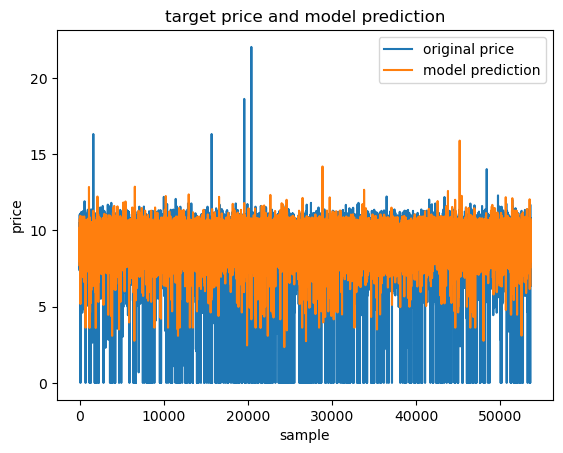

In [32]:
plt.plot(range(0, len(y_test)), y_test)
plt.plot(range(0, len(predictions)), predictions)
plt.legend(['original price', 'model prediction'])
plt.title('target price and model prediction')
plt.xlabel('sample')
plt.ylabel('price')

In [34]:
r = permutation_importance(best_model, X_Test, y_test, n_repeats=30, random_state=0)

In [38]:

for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f'{X_Test.columns[i]:<50} '
          f'{r.importances_mean[i]:.9f} '
          f' +/- {r.importances_std[i]:.9f}')

onehotencoder__transmission_automatic              3.844069815  +/- 0.033191117
onehotencoder__size_full-size                      3.428204407  +/- 0.019676213
onehotencoder__size_mid-size                       3.058429562  +/- 0.028335559
onehotencoder__type_sedan                          2.601127713  +/- 0.017319355
onehotencoder__transmission_other                  2.435042067  +/- 0.020191616
onehotencoder__drive_fwd                           2.316941095  +/- 0.020874952
onehotencoder__drive_4wd                           2.266596428  +/- 0.020534272
onehotencoder__transmission_manual                 1.932322174  +/- 0.017182630
onehotencoder__size_compact                        1.893085439  +/- 0.014568811
onehotencoder__drive_rwd                           1.719676770  +/- 0.018139748
onehotencoder__type_SUV                            1.687584197  +/- 0.016585411
onehotencoder__type_coupe                          1.067325538  +/- 0.011544625
onehotencoder__type_truck               

In [ ]:
# try to grid search degree and alpha (this is **computationally expensive**)
ridge_pipe = Pipeline([('poly', PolynomialFeatures(include_bias=False)), 
                       ('scaler', StandardScaler()), 
                       ('ridge', Ridge())])
search_grid = {'poly__degree': range(1,4), 'ridge__alpha': 10 ** np.linspace(-5, 4, 10)}

ridge_grid = GridSearchCV(ridge_pipe,
                          param_grid = search_grid,
                          cv = 5,
                          scoring = 'neg_mean_squared_error')
ridge_grid.fit(X, y)
best_model = ridge_grid.best_estimator_
best_model

## 4. Model with LASSO regression


In [39]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning, module='sklearn.linear_model')

In [40]:
lasso_pipe = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)), 
                       ('scaler', StandardScaler()), 
                       ('lasso', Lasso())])
search_grid = {'lasso__alpha': 10 ** np.linspace(-5, 4, 10)}

lasso_grid = GridSearchCV(lasso_pipe,
                          param_grid = search_grid,
                          cv = 5,
                          scoring = 'neg_mean_squared_error')
lasso_grid.fit(X, y)
best_model = lasso_grid.best_estimator_
best_model

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=np.float64(1e-05)))])

In [42]:
print(f'Best alpha = {best_model.named_steps['lasso'].alpha}')
best_mse = mean_squared_error(best_model.predict(X_Test), y_test)
print(f'best mse = {best_mse}')

Best alpha = 1e-05
best mse = 0.9458731567833413


Text(0, 0.5, 'price')

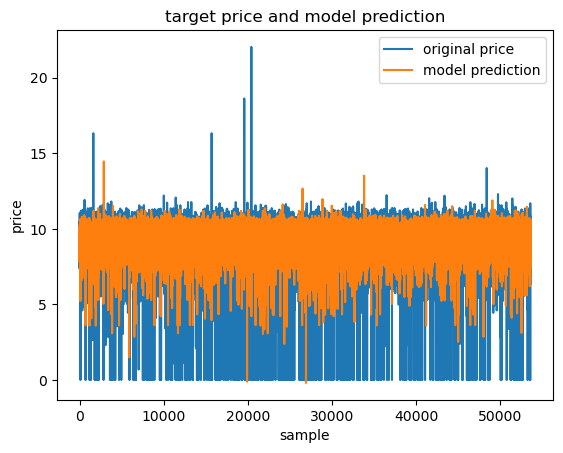

In [47]:
predictions = best_model.predict(X_Test)
plt.plot(range(0, len(y_test)), y_test)
plt.plot(range(0, len(predictions)), predictions)
plt.legend(['original price', 'model prediction'])
plt.title('target price and model prediction')
plt.xlabel('sample')
plt.ylabel('price')

In [44]:
r = permutation_importance(best_model, X_Test, y_test, n_repeats=30, random_state=0)

In [45]:
for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f'{X_Test.columns[i]:<50} '
          f'{r.importances_mean[i]:.9f} '
          f' +/- {r.importances_std[i]:.9f}')

ordinalencoder-1__condition                        0.255765691  +/- 0.006092737
onehotencoder__transmission_other                  0.200483114  +/- 0.004483080
remainder__odometer                                0.080728247  +/- 0.001363400
remainder__year                                    0.078406864  +/- 0.001204889
onehotencoder__size_compact                        0.071630083  +/- 0.002017199
onehotencoder__transmission_automatic              0.060272994  +/- 0.001251218
onehotencoder__size_full-size                      0.056868217  +/- 0.001553322
ordinalencoder-2__cylinders                        0.054811330  +/- 0.001787800
onehotencoder__drive_fwd                           0.044504773  +/- 0.000849716
onehotencoder__type_sedan                          0.040074771  +/- 0.001041446
onehotencoder__transmission_manual                 0.034137731  +/- 0.000995087
onehotencoder__drive_rwd                           0.032372055  +/- 0.001032102
onehotencoder__drive_4wd                

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.